# Results from WandB


## Imports

In [2]:
import wandb
from community.utils.wandb_utils import get_wandb_artifact, get_wandb_runs
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
import json
import seaborn as sns

## Load Results

In [3]:
sweep_path = 'gbena/funcspec/mjw4dzu9'
sweep_id = sweep_path.split('/')[-1]
total_data = pd.read_pickle(f'../../results/sweep_tables/{sweep_id}')
total_data.columns, total_data.shape

(Index(['Step', 'best_acc', 'n_hidden', 'sparsity', 'mean_corr_det',
        'mean_corr_det_norm_1', 'mean_corr_det_norm_2',
        'mean_corr_det_norm_fro', 'mean_corr_global_diff', 'bottleneck_det',
        'bottleneck_det_norm_1', 'bottleneck_det_norm_2',
        'bottleneck_det_norm_fro', 'bottleneck_global_diff', 'name'],
       dtype='object'),
 (3940, 15))

## Plot Smooth Heatmap

In [30]:
filtered_data = total_data[(total_data['Step'] == 1)]
filtered_data.shape

(1970, 15)

In [31]:
y_values, x_values, z_values_diff, z_values_det = filtered_data[['sparsity', 'n_hidden', 'bottleneck_global_diff', 'bottleneck_det_norm_fro']].values.T

In [38]:
def compute_and_plot(x_values, y_values, z_values, log_scale=False, plot=False) : 

    smoothness = 5
    resolution = 500

    def gaussian_filter(x, y, sigmas) : 

        try : 
            filter = np.exp(-(x**2/sigmas[0]**2 + y**2/sigmas[1]**2))
        except : 

            sigma = [s.mean() for s in sigmas]
            filter = np.exp(-(x**2/sigma[0]**2 + y**2/sigma[1]**2))

        return filter
        
    def weighted_average(x, y, sigmas) : 

        return (z_values * gaussian_filter(x - x_values, y - y_values, sigmas)).sum() / gaussian_filter(x - x_values, y - y_values, sigmas).sum()


    def plot_filters(sigmas) :
        Y = np.linspace(y_values.min(), y_values.max(), 100)
        X = np.linspace(x_values.min(), x_values.max(), 100)

        points = [10, 50, 90]

        fig, axs = plt.subplots(1, len(points), figsize=(10, 5))
        for p, ax in zip(points, axs) : 
                
            point = [X[p], Y[p]]
            filter = lambda x, y : gaussian_filter( (x - point[0]), y - point[1], sigmas=sigmas).mean()
            Z = np.array([[filter(x, y) for x in X] for y in Y])
            sns.heatmap(Z, ax=ax)

    if log_scale : 
        X = np.linspace(x_values.min(), x_values.max(), resolution)
        Y = np.linspace(y_values.min(), y_values.max(), resolution) #500 x 500 takes 10s
    else : 
        X = np.geomspace(x_values.min(), x_values.max(), resolution)
        Y = np.geomspace(y_values.min(), y_values.max(), resolution)
        #print(Y)

    Xm, Ym = np.meshgrid(X, Y)

    #ratio = (Ym/Xm)
    #sigmas = np.array([np.ones_like(ratio), 4*ratio])*smoothness

    ratio = (y_values / x_values).mean()
    sigmas = np.array([1, 3*ratio])*smoothness

    vect_avg = np.vectorize(lambda x, y : weighted_average(x, y, sigmas), signature=('(),()->()'))
    Z = vect_avg(Xm, Ym)

    if plot : plot_filters(sigmas)

    plt.figure(figsize=(20, 10))
    plt.pcolormesh(X, Y, Z, cmap='viridis')
    if log_scale : 
        ''
        plt.xscale('log')
        plt.yscale('log')

    plt.ylim(y_values.min(), y_values.max())
    plt.xlim(x_values.min(), x_values.max())

        
    #plt.grid(True)
    plt.colorbar()

    return X, Y, Z, sigmas

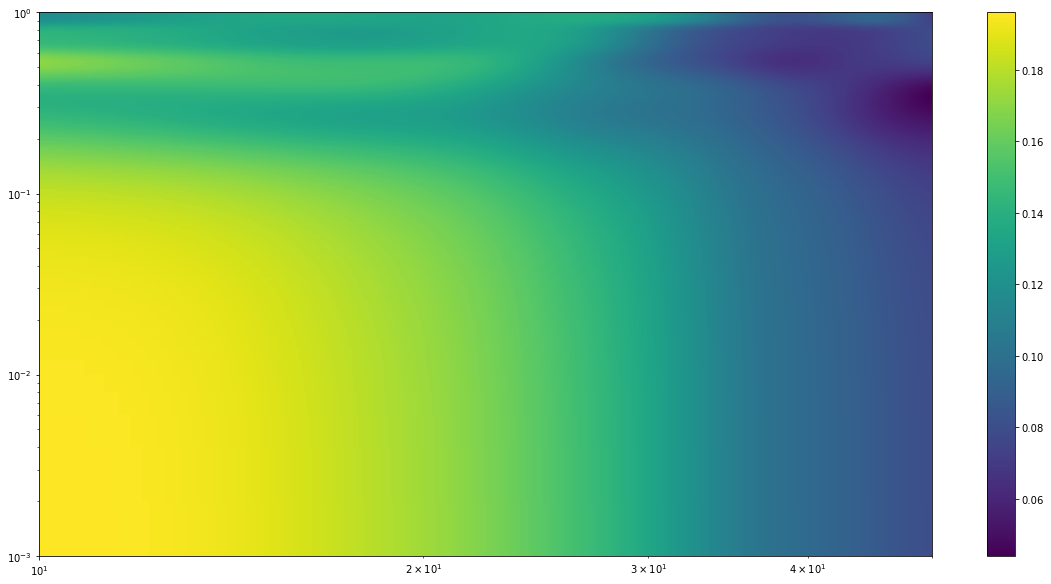

In [39]:
X, Y, Z_diff, sigmas = compute_and_plot(x_values, y_values, z_values_diff, True, False)

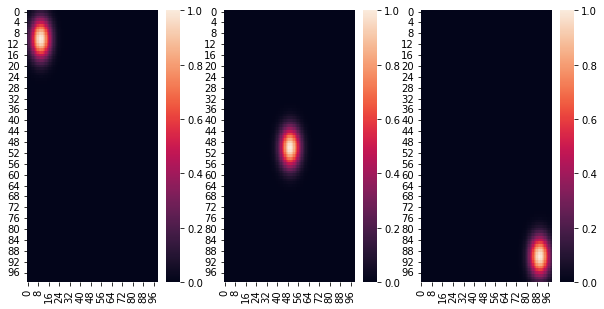

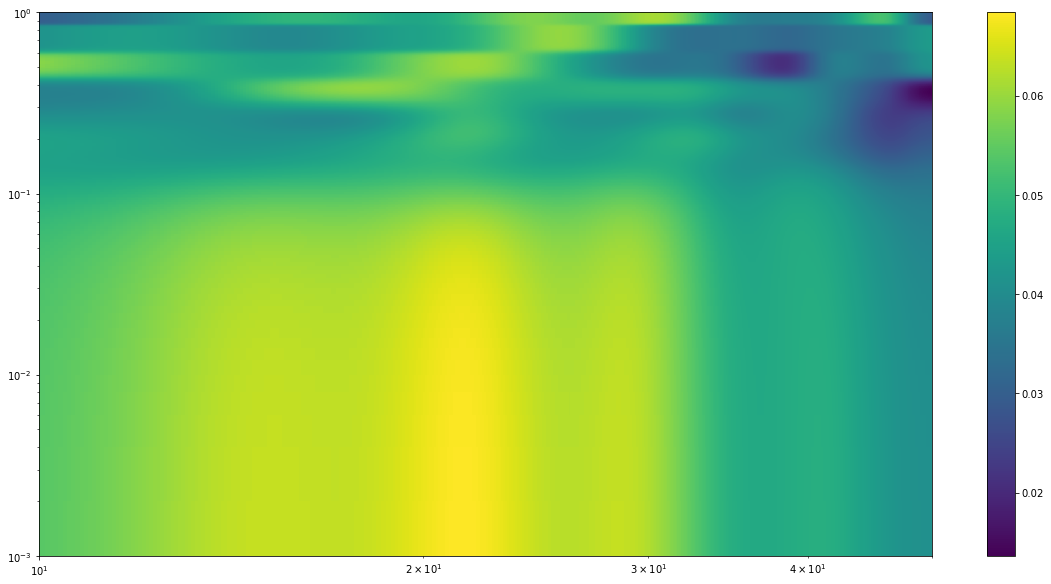

In [36]:
X, Y, Z_det, sigmas = compute_and_plot(x_values, y_values, z_values_det, True, True)

In [9]:
np.linspace(10, 30, 11)

array([10., 12., 14., 16., 18., 20., 22., 24., 26., 28., 30.])

In [10]:
1/20**2

0.0025

In [11]:
plt.plot(filter(5, 0.1))

TypeError: 'float' object is not iterable